# Clustering

## With K-Means & Hierarchical Clustering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram, fcluster
from sklearn.cluster import KMeans
from kneed import KneeLocator

from helper_functions import cm_to_inch 

In [2]:
plt.style.use(['seaborn-whitegrid'])
plt.rcParams["font.family"] = "Times new roman"
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

In [3]:
week_dist_matrix = pd.read_excel('week_dist_matrix.xlsx', index_col=0)

In [4]:
def hierarchical_clustering(distance_matrix, method='complete'):
    if method == 'complete':
        Z = complete(distance_matrix)
    if method == 'single':
        Z = single(distance_matrix)
    if method == 'average':
        Z = average(distance_matrix)
    if method == 'ward':
        Z = ward(distance_matrix)
    
    return Z

In [10]:
def plot_dendrogram(linkage_matrix, save_path=None):
    plt.figure(figsize=(cm_to_inch(29), cm_to_inch(20)))
    # plt.title('Hierarchical Clustering Dendrogram', fontsize=15)
    # plt.xlabel('Clusters', fontsize=15)
    # plt.ylabel('Distance', fontsize=15)
    plt.xlabel('Gruče', fontsize=15)
    plt.ylabel('Razdalja', fontsize=15)
    
    # dendrogram plot
    ddata = dendrogram(linkage_matrix, orientation='top',
               truncate_mode='lastp', p=5,
               labels=True, get_leaves=True,
               show_leaf_counts=True,
               show_contracted=True)
    
    # cluster points & distance labels plot
    limit = 4
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
        x = sum(i[1:3]) / 2
        y = d[1]
        if y > limit:
            plt.plot(x, y, 'o', c=c, markeredgewidth=0)
            plt.annotate(int(y), (x, y), xytext=(0, -5),
                        textcoords='offset points',
                        va='top', ha='center', fontsize=15)
    
    # distance plot
    line = 84
    plt.axhline(y=line, c='black', linestyle='--')
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        plt.close()

In [6]:
linkage_matrix = hierarchical_clustering(week_dist_matrix, method='ward')

C:\Users\Luka\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [11]:
plot_dendrogram(linkage_matrix, save_path='images/dendrogram_cutoff.jpg')

In [10]:
def kmeans_elbow_method(input_matrix, n_clusters, kmeans_kwargs):
    sse = []
    for k in range(1, n_clusters):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(input_matrix)
        sse.append(kmeans.inertia_)
    return sse

In [12]:
def elbow_method_plot(sse, n_clusters, save_path=None):
    plt.figure(figsize=(cm_to_inch(20), cm_to_inch(20)))
    # plt.title('Elbow Method', fontsize=15)
    plt.style.use('fivethirtyeight')
    plt.plot(range(1, n_clusters), sse)
    # plt.xlabel('Number of Clusters', fontsize=15)
    plt.xlabel('Število grup', fontsize=15)
    plt.ylabel('SSE', fontsize=15)
    
    # elbow point
    k1 = KneeLocator(range(1, n_clusters), sse, curve='convex', direction='decreasing')
    plt.vlines(x=k1.elbow, ymin=0, ymax=35000, linestyle='--')
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        plt.close()

In [13]:
kmeans_kwargs = {
    'init': 'random', 'n_init': 10, 'max_iter': 300, 'random_state': 42
}

sse = kmeans_elbow_method(week_dist_matrix, 11, kmeans_kwargs)

In [14]:
elbow_method_plot(sse, 11, save_path='images/elbow.jpg')

# K-Means vs Hierarchical Clustering

## Comparing cluster sizes

In [12]:
def cluster_size(cluster_labels):
    
    cluster_obj = dict()
    for i in cluster_labels:
        if i in cluster_obj:
            cluster_obj[i] += 1
        else:
            cluster_obj[i] = 0
            cluster_obj[i] += 1
            
    cluster_obj = dict(sorted(cluster_obj.items(), key=lambda item: item[1], reverse=True)) 
    keys = list(k for k in range(len(np.unique(cluster_labels))))
    cluster_obj = dict(zip(keys, list(cluster_obj.values())))
        
    return cluster_obj

In [13]:
# creating clusters 
# hierarchical clustering
hc_cluster_labels = fcluster(linkage_matrix, 84, criterion='distance')
print(np.unique(hc_cluster_labels))

# kmeans clustering
km_cluster_labels = KMeans(init='random', n_clusters=3, n_init=10, max_iter=300, random_state=42).fit_predict(week_dist_matrix)
print(np.unique(km_cluster_labels))

[1 2 3]
[0 1 2]


In [14]:
hc_obj = cluster_size(hc_cluster_labels)
km_obj = cluster_size(km_cluster_labels)

display(hc_obj, km_obj)

{0: 2080, 1: 341, 2: 108}

{0: 2266, 1: 222, 2: 41}

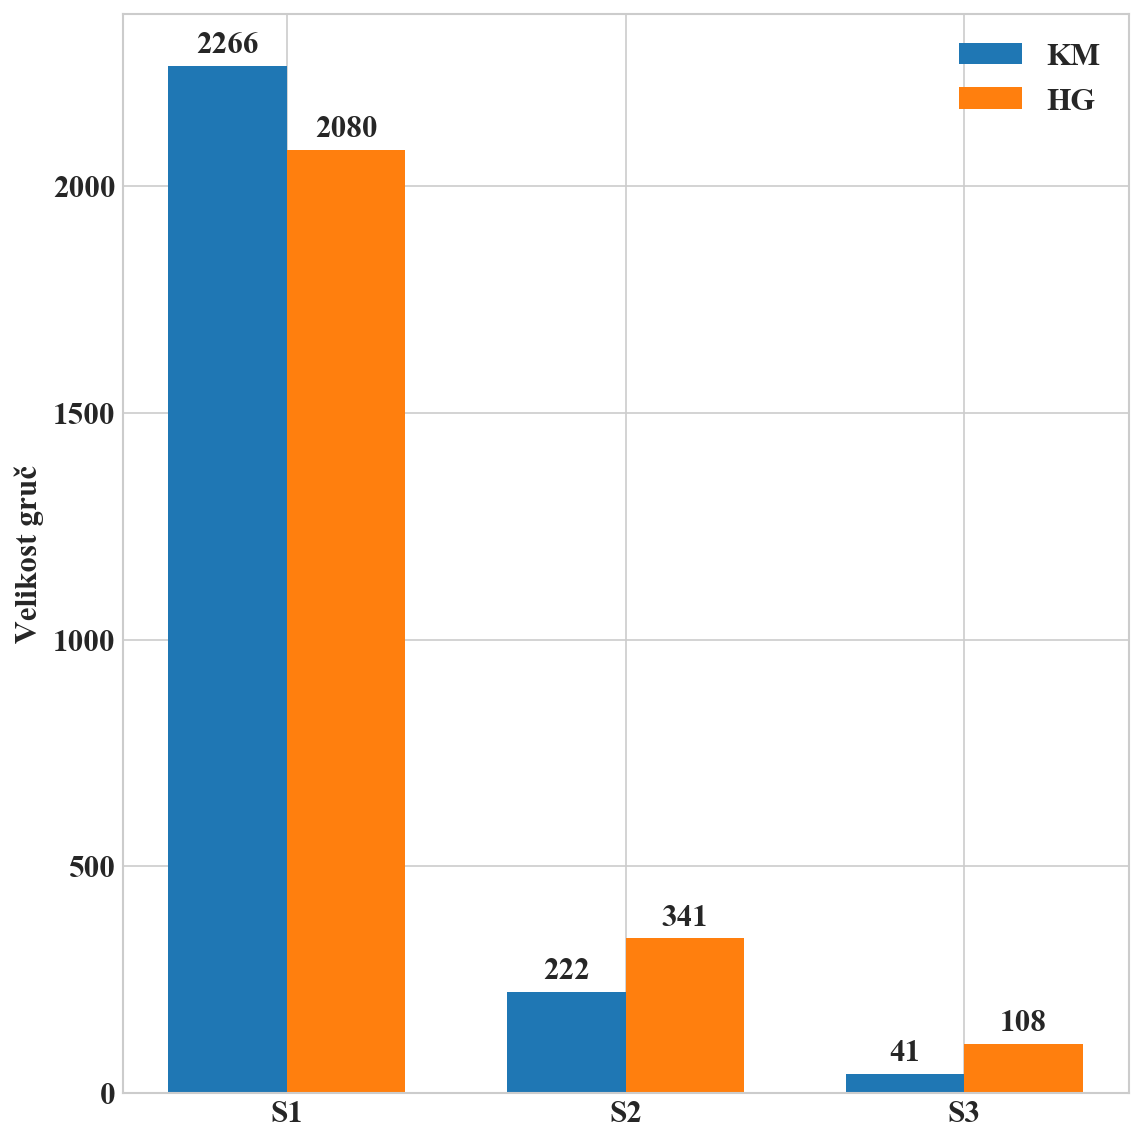

In [23]:
labels = ['S1', 'S2', 'S3']
km_data = [km_obj[i] for i in range(len(km_obj))]
hc_data = [hc_obj[i] for i in range(len(hc_obj))]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(cm_to_inch(20), cm_to_inch(20)))
rects1 = ax.bar(x - width/2, km_data, width, label='KM')
rects2 = ax.bar(x + width/2, hc_data, width, label='HG')

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Cluster size')
ax.set_ylabel('Velikost gruč', fontsize=15)
# ax.set_title('Cluster size by group and method')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=15)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
        
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('images/cluster_size_comparison.jpg', dpi=200, bbox_inches='tight')

plt.show()

## Comparing user profiles inside clusters

In [15]:
usernames = pd.read_csv('profiles_translation.csv', index_col=0)
up_week = pd.read_excel('weekly_user_profiles.xlsx', index_col=0)

In [16]:
UN = usernames.columns[0]

In [17]:
def user_groups_from_cluster(cluster_labels):
    group_user = []
    for i in np.unique(cluster_labels):
        group_user.append([count for count, ii in enumerate(cluster_labels) if ii == i])
    return group_user

In [29]:
def user_group_plot(user_group, title=None, save_path=None):
    plt.figure(figsize=(cm_to_inch(10), cm_to_inch(10)))
    plt.title(title, fontsize=15)
    select = []
    for i in user_group:
        select.append(usernames.at[i, UN])
        plt.plot(up_week[usernames.at[i, UN]], alpha=0.1, lw=1)
    plt.plot(up_week[select].mean(axis=1), alpha=1, lw=2, color='black')
    plt.xlabel('t[h]', fontsize=15)
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        plt.close()
    plt.show()    

In [ ]:
hc_group = user_groups_from_cluster(hc_cluster_labels)

In [21]:
user_group_plot(hc_group[2], title='Gruča HG - S1', save_path='images/group_hc_s1.jpg')

In [30]:
user_group_plot(hc_group[1], title='Gruča HG - S2', save_path='images/group_hc_s2.jpg')

In [32]:
user_group_plot(hc_group[0], title='Gruča HG - S3', save_path='images/group_hc_s3.jpg')

In [24]:
km_group = user_groups_from_cluster(km_cluster_labels)

In [25]:
user_group_plot(km_group[2], title='Gruča KM - S1', save_path='images/group_km_s1.jpg')

In [31]:
user_group_plot(km_group[1], title='Gruča KM - S2', save_path='images/group_km_s2.jpg')

In [33]:
user_group_plot(km_group[0], title='Gruća KM - S3', save_path='images/group_km_s3.jpg')

In [133]:
print(len(hc_group[0]))
print(len(hc_group[1]))
print(len(hc_group[2]))

108
341
2080


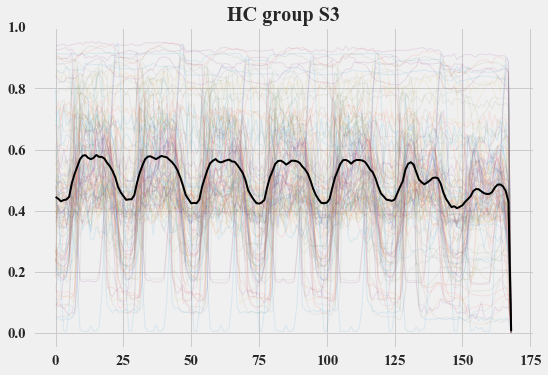

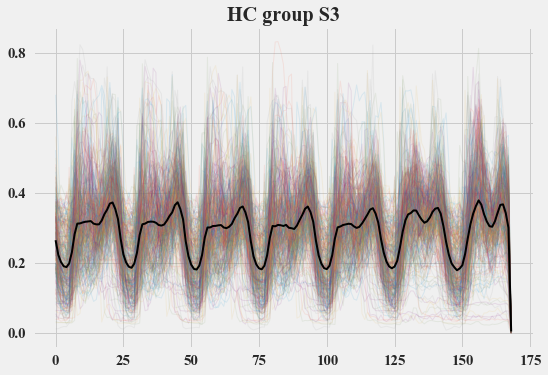

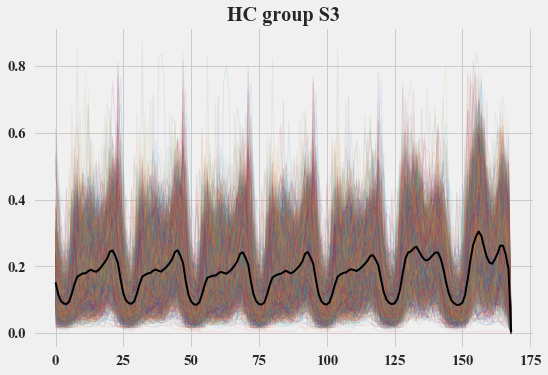

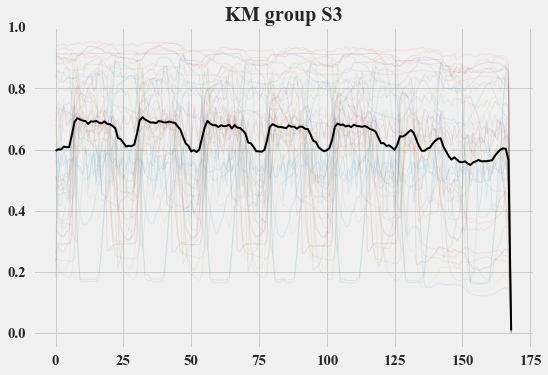

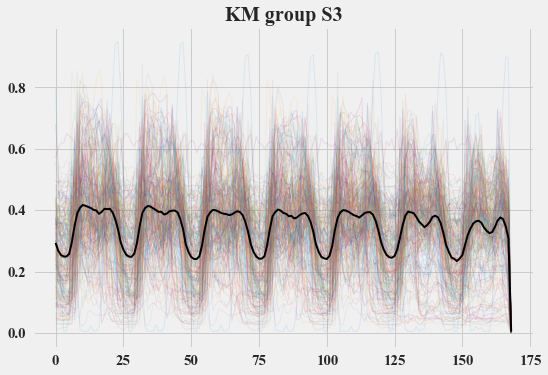

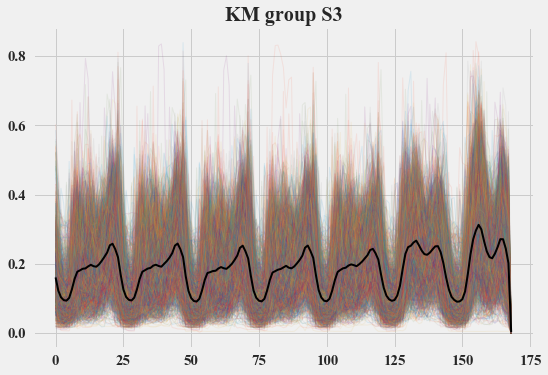

In [139]:
num_of_group = 3
name_of_group = 'S{}'.format(num_of_group)
for u in hc_obj.keys():
    select = []
    plt.title('HC group {}'.format(name_of_group))
    for i in hc_group[u]:
        select.append(usernames.at[i, UN])
        plt.plot(up_week[usernames.at[i, UN]], alpha=0.1, lw=1)
    num_of_group -= 1
    plt.plot(up_week[select].mean(axis=1), alpha=1, lw=2, color='black')
    plt.show()

num_of_group = 3
for u in km_obj.keys():
    select = []
    plt.title('KM group {}'.format(name_of_group))
    for i in km_group[u]:
        select.append(usernames.at[i, UN])
        plt.plot(up_week[usernames.at[i, UN]], alpha=0.1, lw=1)
    plt.plot(up_week[select].mean(axis=1), alpha=1, lw=2, color='black')
    plt.show()